In [32]:
import pandas as pd
import os
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from tqdm.notebook import trange, tqdm
import numpy as np
import ipywidgets as widgets

In [44]:
# Set plotly as the plotting engine for pandas for convenience
pd.options.plotting.backend = "plotly"

In [66]:
# Get a list of all the csv files to process
csv_files = []
for file in os.listdir("../data/raw/firstratedata_futures"):
    if file.endswith(".csv"):
        csv_files.append(file)
csv_files.sort()

In [150]:
# Construct two lists of unique contract months and years respectively
contracts = list(map(lambda file: file[:-4], csv_files))
unique_contract_years = list(set(map(lambda contract: contract[-2:], contracts)))
unique_contract_years.sort()
unique_contract_years = ['All'] + unique_contract_years
unique_contract_months = list(set(map(lambda contract: contract[-3], contracts)))
unique_contract_months.sort()
unique_contract_months = ['All'] + unique_contract_months

In [129]:
month_filter_widget = widgets.ToggleButtons(
    options=unique_contract_months,
    description='Month:',
    disabled=False,
    button_style=''
)
display(month_filter_widget)

ToggleButtons(description='Month:', options=('All', 'G', 'J', 'M', 'Q', 'V', 'Z'), value='All')

In [130]:
year_filter_widget = widgets.ToggleButtons(
    options=unique_contract_years,
    description='Year:',
    disabled=False,
    button_style=''
)
display(year_filter_widget)

ToggleButtons(description='Year:', options=('All', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17',…

In [176]:
contracts_to_analyze = contracts
if (month_filter_widget.value is not None) and (month_filter_widget.value != 'All'):
    contracts_to_analyze = list(filter(lambda contract: contract[-3] == month_filter_widget.value, contracts_to_analyze))
if (year_filter_widget.value is not None) and (year_filter_widget.value != 'All'):
    contracts_to_analyze = list(filter(lambda contract: contract[-2:] == year_filter_widget.value, contracts_to_analyze))
print('Analyzing the following contracts: ' + ', '.join(contracts_to_analyze))

Analyzing the following contracts: LEG09, LEG10, LEG11, LEG12, LEG13, LEG14, LEG15, LEG16, LEG17, LEG18, LEG19, LEG20, LEJ08, LEJ09, LEJ10, LEJ11, LEJ12, LEJ13, LEJ14, LEJ15, LEJ16, LEJ17, LEJ18, LEJ19, LEJ20, LEM08, LEM09, LEM10, LEM11, LEM12, LEM13, LEM14, LEM15, LEM16, LEM17, LEM18, LEM19, LEM20, LEQ08, LEQ09, LEQ10, LEQ11, LEQ12, LEQ13, LEQ14, LEQ15, LEQ16, LEQ17, LEQ18, LEQ19, LEQ20, LEV08, LEV09, LEV10, LEV11, LEV12, LEV13, LEV14, LEV15, LEV16, LEV17, LEV18, LEV19, LEV20, LEZ08, LEZ09, LEZ10, LEZ11, LEZ12, LEZ13, LEZ14, LEZ15, LEZ16, LEZ17, LEZ18, LEZ19, LEZ20


In [4]:
def convert_csv_to_df(filename):
    df_volume = pd.read_csv(f"../data/raw/firstratedata_futures/{filename}", parse_dates=['DateTime'], index_col=['DateTime'])
    return df_volume

In [5]:
def get_unique_trading_days(df):
    '''Calculate the number of unique trading days in the dataset'''
    unique_trading_days = df.index.map(lambda t: t.date()).unique()
    return unique_trading_days

In [6]:
def resample_volume_by_minute(df):
    '''Resample the data-set by minute filling in the gaps and summing the trading volume within each minute'''
    df_volume_by_minute = df.resample('1T').sum()[["Volume"]]
    return df_volume_by_minute

In [7]:
def group_by_minute(df_volume_by_minute):
    '''Group minutes across days together so that we now have the total volume by minute across all days in the dataset'''
    df_volume_by_minute_grouped = df_volume_by_minute.groupby(lambda x: x.time()).sum().rename(columns={'Volume':'Total Volume'})
    return df_volume_by_minute_grouped
    # df_volume_by_minute_grouped.iloc[0:5]
    

In [8]:
def calculate_avg_vol_per_minute(df, num_unique_trading_days):
    '''Calculate the average volume per minute by dividing the total volume per minute by the number of unique trading days'''
    df['Daily Avg Volume'] = df.apply(lambda row: row / num_unique_trading_days )
    return df

In [9]:
# Define a function that returns an array of normalized values given an ndarray of nominal values
def normalize_nd_array(to_normalize):
    '''train the normalization'''
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(to_normalize)
    # print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    # normalize the dataset and print the first 5 rows
    normalized = scaler.transform(to_normalize)
    normalized = list(map(lambda x: x[0], normalized.tolist()))
    # for i in range(5):
    # 	print(normalized[i])
    return normalized

In [10]:
def calculate_normalized_volume(df):
    '''Create an array containing the series of total volume values'''
    total_volume_values = df['Total Volume'].values
    # Convert the array into a matrix (this format is needed for the normalization functions)
    total_volume_matrix = total_volume_values.reshape((len(total_volume_values), 1))
    # Return an array of normalized values
    normalized_values = normalize_nd_array(total_volume_matrix)
    # Add the column containing the normalized values to the dataframe
    df_volume_by_minute_grouped['Total Volume Per Minute (Normalized)'] = normalized_values
    # df_volume_by_minute_grouped.iloc[1420:1425]
    return df_volume_by_minute_grouped

In [11]:
def create_dataframes_for_volume_grouped_by_minute(df_volume_by_minute, unique_trading_days, contract_symbol):
    '''
    Create and populate an array of dataframes. Each dataframe contains one trading days worth of volume values grouped by minute
    and normalized against just that days worth of activity
    '''
    frames = []
    for i in trange(len(unique_trading_days), desc=f"{contract_symbol} - Splitting into dataframes grouped by minute"):
        day=unique_trading_days[i]
        string_date = day.strftime("%Y-%m-%d")
        days_df = df_volume_by_minute.loc[string_date]
        volume_values = days_df['Volume'].values
        volume_values = volume_values.reshape((len(volume_values), 1))
        normalized_day_volume = normalize_nd_array(volume_values)
        days_df['Volume Normalized Intraday'] = normalized_day_volume
        frames.append(days_df.copy())
    return frames

In [12]:
def concat_to_single_df(frames):
    '''Concatenate the entire array of dataframes back into one big dataframe that contains the Volume Normalized Intraday values for every minute of every day'''
    df_intraday_normalized = pd.concat(frames)
    return df_intraday_normalized
    # Show a small sample
    # df_intraday_normalized.iloc[170000:170005]

In [13]:
# Returns the volume Normalized intraday Avg
def calculate_normalized_vol_by_minute(intraday_summed, num_unique_trading_days):
    return intraday_summed / num_unique_trading_days

In [14]:
def group_by_minute_sum_normalized_volumes(df_intraday_normalized):
    '''Group by minute across all days summing the intraday normalized volumes'''
    df_normalized_grouped_by_minute = df_intraday_normalized.groupby(lambda x: x.time()).sum().rename(columns={'Volume Normalized Intraday':'Volume Normalized Summed'})
    # Add a column that shows the average intraday normalized volume for each minute
    df_normalized_grouped_by_minute['Daily Avg Volume Normalized'] = df_normalized_grouped_by_minute.apply(
        lambda row: calculate_normalized_vol_by_minute(row['Volume Normalized Summed'],
                                                       num_unique_trading_days),
        axis=1
    )
    return df_normalized_grouped_by_minute

In [15]:
def initialize_df_grouped_by_minute():
    '''Initialize an empty dataframe with no data and an index with a row for each minute of the day'''
    date_range = pd.date_range(start='1/1/2021', end='1/02/2021', freq='T')[:-1]
    new_df = pd.DataFrame(data={'DateTime':date_range}).set_index('DateTime')
    new_df = new_df.groupby(lambda x: x.time()).sum()
    return new_df

In [24]:
# Iterate over each contract and perform analysis to create charts
master_avg_daily_nominal_df = initialize_df_grouped_by_minute()
master_avg_daily_normalized_df = initialize_df_grouped_by_minute()
for i in trange(len(csv_files), desc=f"Overall Analysis"):
    file = csv_files[i]
    contract_symbol = file[:len(file) - 4]
    df = convert_csv_to_df(file)
    # print("Initial dataframe")
    # display(df)
    unique_trading_days = get_unique_trading_days(df)
    num_unique_trading_days = len(unique_trading_days)
    # print(f"Unique trading days = {num_unique_trading_days}")
    df_volume_by_minute = resample_volume_by_minute(df)
    # print(f"\ndf_volume_by_minute {contract_symbol}")
    # display(df_volume_by_minute)
    df_volume_by_minute_grouped = group_by_minute(df_volume_by_minute)
    # print("\ndf_volume_by_minute_grouped")
    # display(df_volume_by_minute_grouped)
    df_volume_by_minute_grouped = calculate_avg_vol_per_minute(df_volume_by_minute_grouped, num_unique_trading_days)
    # print("\ndf_volume_by_minute_grouped")
    # display(df_volume_by_minute_grouped)
    frames = create_dataframes_for_volume_grouped_by_minute(df_volume_by_minute, unique_trading_days, contract_symbol)
    # Show a small sample
    # print("\nSample of volume normalized intraday")
    # display(frames[125][614:618])
    df_intraday_normalized = concat_to_single_df(frames)
    # Show a small sample
    # print("\ndf_intraday_normalized sample")
    # display(df_intraday_normalized.iloc[170000:170005])
    df_normalized_grouped_by_minute = group_by_minute_sum_normalized_volumes(df_intraday_normalized)
    # Show a small sample
    # print("\ndf_normalized_grouped_by_minute")
    # display(df_normalized_grouped_by_minute[500:510])
    # Copy the columns from the intermediate dataframes to the master one which will be used for charting
    master_avg_daily_nominal_df[f"{contract_symbol}"] = df_volume_by_minute_grouped['Daily Avg Volume'].copy()
    master_avg_daily_normalized_df[f"{contract_symbol}"] = df_normalized_grouped_by_minute['Daily Avg Volume Normalized'].copy()

Overall Analysis:   0%|          | 0/6 [00:00<?, ?it/s]

LEG19 - Splitting into dataframes grouped by minute:   0%|          | 0/366 [00:00<?, ?it/s]

LEJ19 - Splitting into dataframes grouped by minute:   0%|          | 0/365 [00:00<?, ?it/s]

LEM19 - Splitting into dataframes grouped by minute:   0%|          | 0/361 [00:00<?, ?it/s]

LEQ19 - Splitting into dataframes grouped by minute:   0%|          | 0/372 [00:00<?, ?it/s]

LEV19 - Splitting into dataframes grouped by minute:   0%|          | 0/362 [00:00<?, ?it/s]

LEZ19 - Splitting into dataframes grouped by minute:   0%|          | 0/358 [00:00<?, ?it/s]

In [30]:
    figures = []
    fig1 = master_avg_daily_nominal_df.plot(kind="line", title=f"Average Daily Nominal Trading Volume By Minute")
    fig2 = master_avg_daily_normalized_df.plot(kind="line", title=f"Average Daily Normalized Trading Volume By Minute")
    figures.append(fig1)
    figures.append(fig2)

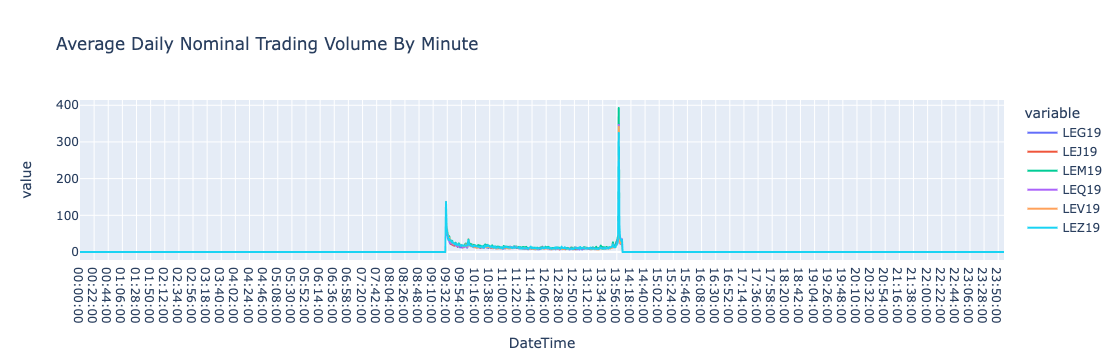

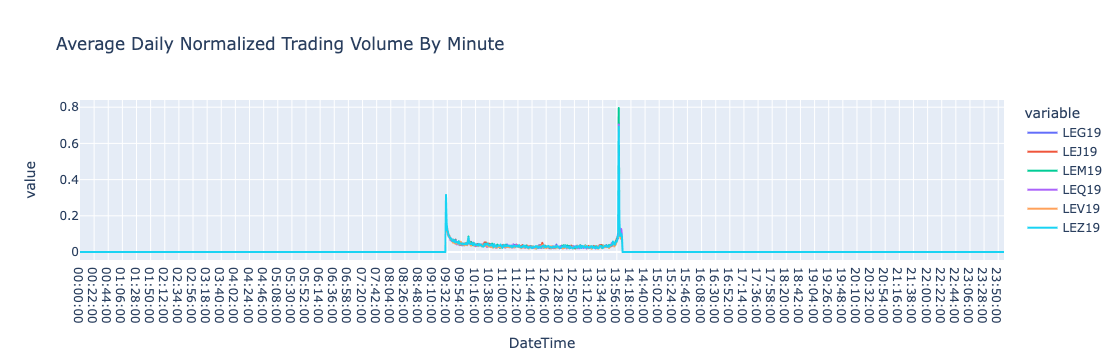

In [31]:
# show the charts in the notebook
for fig in figures:
    fig.show()